In [1]:
# Magnetic moment classifier using SVM
# https://arxiv.org/abs/1806.07989

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [234]:
import itertools
import os

import pandas as pd
import numpy as np

from sklearn.model_selection import GridSearchCV, KFold
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, \
                            classification_report, confusion_matrix
from sklearn.svm import SVC

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mlxtend.plotting import plot_decision_regions

from tqdm.notebook import tqdm

In [362]:
normalizer = Normalizer()

df_train = pd.read_csv('../datasets/datatrain.csv')
df_test = pd.read_csv('../datasets/datatest.csv')

X_train = df_train.drop(['structure', 'class'], axis=1)
X_train_norm = normalizer.fit_transform(X_train)
y_train = df_train['class'].values

X_test = df_test.drop(['structure', 'class'], axis=1)
X_test_norm = normalizer.fit_transform(X_test)
y_test = df_test['class'].values

In [377]:
kernel = ['linear', 'rbf', 'poly']

param_grid = {
    'kernel': kernel,
    'C': [0.1, 1, 10, 100, 1000],
    'gamma': [0.1, 0.01, 0.001, 0.0001, 0.00001]
}

In [398]:
grid1 = GridSearchCV(estimator=SVC(), param_grid=param_grid, cv=5, refit=True)
grid1.fit(X_train_norm, y_train)

y_pred1 = grid1.predict(X_test_norm)

print('Best score: {}'.format(grid1.score(X_test_norm, y_test)))
print('Best params: {}'.format(grid1.best_params_))

print('SVM accuracy with best params: {}'.format(accuracy_score(y_pred1, y_test)))
print('Actual test label:    {}'.format(y_test))
print('Predicted test label: {}\n'.format(y_pred1))

print(confusion_matrix(y_test, y_pred1), '\n')

print('Precision: {}'.format(precision_score(y_test, y_pred1)))
print('Recall: {}'.format(recall_score(y_test, y_pred1)))
print('F Score: {}'.format(f1_score(y_test, y_pred1)))

Best score: 0.9333333333333333
Best params: {'C': 1000, 'gamma': 0.1, 'kernel': 'linear'}
SVM accuracy with best params: 0.9333333333333333
Actual test label:    [0 0 0 0 0 0 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0]
Predicted test label: [0 0 0 0 0 0 1 1 1 1 1 1 0 0 1 0 1 1 1 1 1 1 1 1 0 0 0 0 0 0]

[[15  2]
 [ 0 13]] 

Precision: 0.8666666666666667
Recall: 1.0
F Score: 0.9285714285714286


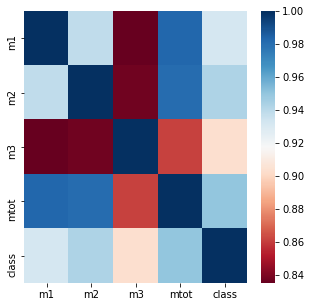

In [423]:
# selected = ['m1', 'm2', 'm3', 'mtot', 'n_el', 'tot_en', 'z3', 'z5', 'z6', 'z7']
# selected = ['m1', 'm2', 'm3', 'mtot', 'z3', 'z5', 'z6', 'z7']
selected = ['m1', 'm2', 'm3', 'mtot']

plt.figure(figsize=(5, 5))
df_corr = pd.concat([pd.DataFrame(X_train, columns=selected), df_train['class']], axis=1)
sns.heatmap(df_corr.corr(), annot=False, cmap='RdBu')

In [424]:
X_train2 = df_train[selected]
X_train2_norm = normalizer.fit_transform(X_train2)

X_test2 = df_test[selected]
X_test2_norm = normalizer.fit_transform(X_test2)

In [425]:
grid2 = GridSearchCV(estimator=SVC(), param_grid=param_grid, cv=5, refit=True)
grid2.fit(X_train2_norm, y_train)

y_pred2 = grid2.predict(X_test2_norm)

print('Best score: {}'.format(grid2.score(X_test2_norm, y_test)))
print('Best params: {}'.format(grid2.best_params_))

print('SVM Accuracy with best params: {}'.format(accuracy_score(y_pred2, y_test)))
print('Actual test label:    {}'.format(y_test))
print('Predicted test label: {}\n'.format(y_pred2))

print(confusion_matrix(y_test, y_pred2), '\n')

print('Precision: {}'.format(precision_score(y_test, y_pred2)))
print('Recall: {}'.format(recall_score(y_test, y_pred2)))
print('F Score: {}'.format(f1_score(y_test, y_pred2)))

Best score: 0.8333333333333334
Best params: {'C': 100, 'gamma': 0.1, 'kernel': 'linear'}
SVM Accuracy with best params: 0.8333333333333334
Actual test label:    [0 0 0 0 0 0 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0]
Predicted test label: [0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 0 1 0 1 1 1 1 1 1 0 0 0 0 0 0]

[[13  4]
 [ 1 12]] 

Precision: 0.75
Recall: 0.9230769230769231
F Score: 0.8275862068965517


In [412]:
pca = PCA(n_components=2)
pca2 = PCA(n_components=2)

# PCA with all features
X_transformed = pca.fit_transform(X_train)
X_test_transformed = pca.transform(X_test)
columns = ['Principal Component 1', 'Principal Component 2']

df_pca = pd.DataFrame(data=X_transformed, columns=columns)
df_pca = pd.concat([df_pca['Principal Component 1'], df_pca['Principal Component 2'], df_train['class']], axis = 1)

# PCA with selected features
X_transformed2 = pca2.fit_transform(X_train2)
X_test_transformed2 = pca2.transform(X_test2)
columns = ['Principal Component 1', 'Principal Component 2']

df_pca2 = pd.DataFrame(data=X_transformed2, columns=columns)
df_pca2 = pd.concat([df_pca2['Principal Component 1'], df_pca2['Principal Component 2'], df_train['class']], axis=1)

# Variance ratio
print('PCA with all features variance ratio:      {}'.format(pca.explained_variance_ratio_))
print('PCA with selected features variance ratio: {}'.format(pca2.explained_variance_ratio_))

PCA with all features variance ratio:      [0.98037158 0.0137362 ]
PCA with selected features variance ratio: [0.92472301 0.06287929]


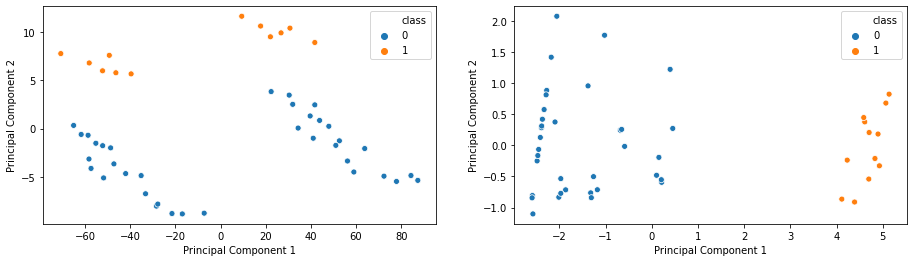

In [413]:
fig, ax = plt.subplots(1,2)
sns.scatterplot(data=df_pca, x='Principal Component 1', y='Principal Component 2', hue='class', ax=ax[0])
sns.scatterplot(data=df_pca2, x='Principal Component 1', y='Principal Component 2', hue='class', ax=ax[1])
plt.subplots_adjust(left=2, right=4)
fig.show()

In [414]:
pipe = [('pca', PCA()), ('classifier', SVC())]
param_grid_pca = {
    'pca__n_components': [2],
    'classifier__kernel': kernel,
    'classifier__C': [0.1, 1, 10, 100, 1000],
    'classifier__gamma': [0.1, 0.01, 0.001, 0.0001, 0.00001]
}

pipeline = Pipeline(pipe)

SVM Accuracy with best params: 0.9333333333333333
Actual test label:    [0 0 0 0 0 0 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0]
Predicted test label: [0 0 0 0 0 0 1 1 1 1 1 1 0 0 1 0 1 1 1 1 1 1 1 1 0 0 0 0 0 0]

[[15  2]
 [ 0 13]] 

Precision: 0.8666666666666667
Recall: 1.0
F Score: 0.9285714285714286


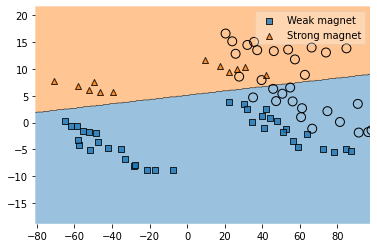

In [415]:
grid3 = GridSearchCV(pipeline, param_grid=param_grid_pca, cv=5)
grid3.fit(X_transformed, y_train)

y_pred3 = grid3.predict(X_test_transformed)

print('SVM Accuracy with best params: {}'.format(accuracy_score(y_pred3, y_test)))
print('Actual test label:    {}'.format(y_test))
print('Predicted test label: {}\n'.format(y_pred3))

print(confusion_matrix(y_test, y_pred3), '\n')

print('Precision: {}'.format(precision_score(y_test, y_pred3)))
print('Recall: {}'.format(recall_score(y_test, y_pred3)))
print('F Score: {}'.format(f1_score(y_test, y_pred3)))

ax = plot_decision_regions(X_transformed, y_train, 
                      clf=grid3, legend=2, 
                      X_highlight=X_test_transformed, zoom_factor=0.1)

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, 
          ['Weak magnet', 'Strong magnet', 'Test data'], 
           framealpha=0.3, scatterpoints=1)

plt.show()

SVM Accuracy with best params: 1.0
Actual test label:    [0 0 0 0 0 0 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0]
Predicted test label: [0 0 0 0 0 0 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0]

[[17  0]
 [ 0 13]] 

Precision: 1.0
Recall: 1.0
F Score: 1.0


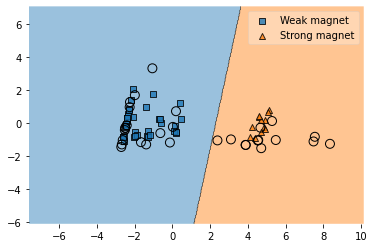

In [416]:
grid4 = GridSearchCV(pipeline, param_grid=param_grid_pca, cv=5)
grid4.fit(X_transformed2, y_train)

y_pred4 = grid4.predict(X_test_transformed2)

print('SVM Accuracy with best params: {}'.format(accuracy_score(y_pred4, y_test)))
print('Actual test label:    {}'.format(y_test))
print('Predicted test label: {}\n'.format(y_pred4))

print(confusion_matrix(y_test, y_pred4), '\n')

print('Precision: {}'.format(precision_score(y_test, y_pred4)))
print('Recall: {}'.format(recall_score(y_test, y_pred4)))
print('F Score: {}'.format(f1_score(y_test, y_pred4)))

ax = plot_decision_regions(X_transformed2, y_train, 
                      clf=grid4, legend=2, 
                      X_highlight=X_test_transformed2, zoom_factor=0.2)

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, 
          ['Weak magnet', 'Strong magnet', 'Test data'], 
           framealpha=0.3, scatterpoints=1)

plt.show()